In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
import numpy as np
from model import unet,unet_backbone

In [2]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = read_voc_images(voc_dir)

In [3]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [4]:
batch_size = 64
train_iter = DataLoader(voc_train, batch_size, shuffle=True,drop_last=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [7]:
model = nn.Sequential(*list(pretrained_net.children())[:-2])

In [8]:
# test model output
X = torch.rand(size=(1, 3, 320, 480))
model(X).shape

torch.Size([1, 512, 10, 15])

In [9]:
num_classes = 21
model.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
model.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [10]:
# bilinear weight initialization
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    # for i in range(in_channels):
    #     for j in range(out_channels):
    #         weight[i,j,:,:] = filt
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [11]:
W = bilinear_kernel(num_classes, num_classes, 64)
model.transpose_conv.weight.data.copy_(W);

In [12]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [13]:

def myloss(inputs,targets):
    return functional.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)


In [14]:
lr = 0.001
# loss function
loss_fn = myloss
# loss_fn = nn.CrossEntropyLoss()
# optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=1e-3)

In [15]:
torch.manual_seed(17)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train(train_dataloader, device, model, loss_fn, optimizer)
    # test(val_dataloader, device, model, loss_fn)
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 233.422714  [    0/ 1114]
Test Error: 
 pixel acc: 79.36%, mean acc: 34.87%, Avg loss: 51.542962 

Epoch 2
-------------------------------
loss: 51.927185  [    0/ 1114]
Test Error: 
 pixel acc: 82.07%, mean acc: 49.58%, Avg loss: 41.742012 

Epoch 3
-------------------------------
loss: 36.974319  [    0/ 1114]
Test Error: 
 pixel acc: 83.55%, mean acc: 37.88%, Avg loss: 35.860676 

Epoch 4
-------------------------------
loss: 28.266441  [    0/ 1114]
Test Error: 
 pixel acc: 84.39%, mean acc: 43.15%, Avg loss: 33.074299 

Epoch 5
-------------------------------
loss: 27.758966  [    0/ 1114]
Test Error: 
 pixel acc: 84.95%, mean acc: 45.56%, Avg loss: 31.375422 

Done!


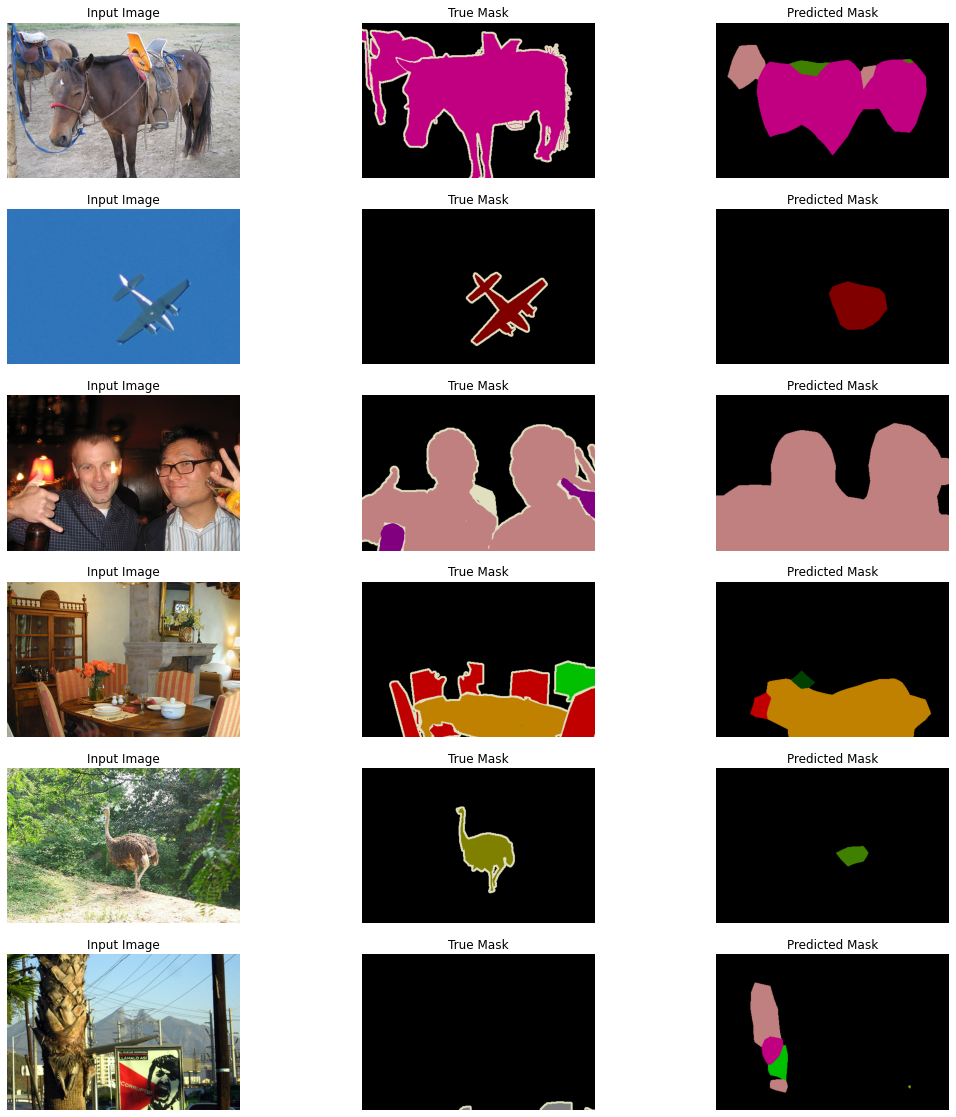

In [20]:
torch.manual_seed(17)
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [18]:
torch.save(model,'FCN-ResNet18-5epochs-seed.pt')

In [22]:
model = torch.load('FCN-ResNet18-5epochs-seed.pt',map_location=device)

In [23]:
torch.manual_seed(17)
# mean iou
model.eval()
# iou = 0
mean_iou = []
with torch.no_grad():
    for X,y in test_iter:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        pred = torch.argmax(pred,1)
        iou = utils.iou(pred,y,21,ignore_background=True)
        iou = np.mean(iou)
        mean_iou.append(iou)
        print(f'this mean iou is :{iou}')
print(f'mean iou for all is: {np.mean(mean_iou)}')

this mean iou is :0.32847191431452066
this mean iou is :0.32567676090055137
this mean iou is :0.3610177442897111
this mean iou is :0.3271559713822979
this mean iou is :0.3697040633698628
this mean iou is :0.3839609547372305
this mean iou is :0.3580609515019608
this mean iou is :0.3673639031549774
this mean iou is :0.3318005634516691
this mean iou is :0.3217591105171832
this mean iou is :0.3126682748340895
this mean iou is :0.3730719150634466
this mean iou is :0.3620913301885841
this mean iou is :0.3717637873083507
this mean iou is :0.34960385222539964
this mean iou is :0.33809427025943545
this mean iou is :0.29833381167793693
mean iou for all is: 0.3459175987751299
